# Introduction
### KDD Cup 2009: Customer relationship prediction
Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling).

The most practical way, in a CRM system, to build knowledge on customer is to produce scores. A score (the output of a model) is an evaluation for all instances of a target variable to explain (i.e. churn, appetency or up-selling). Tools which produce scores allow to project, on a given population, quantifiable information. The score is computed using input variables which describe instances. Scores are then used by the information system (IS), for example, to personalize the customer relationship. An industrial customer analysis platform able to build prediction models with a very large number of input variables has been developed by Orange Labs. This platform implements several processing methods for instances and variables selection, prediction and indexation based on an efficient model combined with variable selection regularization and model averaging method. The main characteristic of this platform is its ability to scale on very large datasets with hundreds of thousands of instances and thousands of variables. The rapid and robust detection of the variables that have most contributed to the output prediction can be a key factor in a marketing application.

The challenge is to beat the in-house system developed by Orange Labs. It is an opportunity to prove that you can deal with a very large database, including heterogeneous noisy data (numerical and categorical variables), and unbalanced class distributions. Time efficiency is often a crucial point. Therefore part of the competition will be time-constrained to test the ability of the participants to deliver solutions quickly.

https://www.kdd.org/kdd-cup/view/kdd-cup-2009

# Modeling churn

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Loading data

In [2]:
'''Features contém as características. O parâmetro 'sep' é o separador dentro do arquivo. 
O parâmetro 'na_filter' informa que não será aplicado filtro para remover os valores faltantes
A variável Outcome contém o as respostas. O parâmetro 'header'informa que não há um cabeçalho 
para indicar o nome das colunas '''

features = pd.read_csv('kdd/orange_small_train.data', sep='\t', na_filter=False)
outcome = pd.read_csv('kdd/orange_small_train_churn.labels', header=None)

In [3]:
'''Verificando as bases de dados. Existem 50 mil registros e 230 colunas'''
features.shape

(50000, 230)

In [4]:
'''Analisando os dados da base. Todos os dados estão mascarados por motivos de privacidade'''
features.head()

Var1 Var2 Var3 Var4 Var5  Var6 Var7 Var8 Var9 Var10  ...   Var221   Var222  \
0                           1526    7                  ...     oslk  fXVEsaq   
1                            525    0                  ...     oslk  2Kb5FSF   
2                           5236    7                  ...  Al6ZaUT  NKv4yOc   
3                                   0                  ...     oslk  CE7uk3u   
4                           1029    7                  ...     oslk  1J2cvxe   

       Var223 Var224 Var225 Var226   Var227         Var228 Var229 Var230  
0  jySVZNlOJy                 xb3V     RAYp  F2FyR07IdsN7I                
1  LM8l689qOp                 fKCe     RAYp  F2FyR07IdsN7I                
2  jySVZNlOJy          kG3k   Qu4f  02N6s8f  ib5G6X1eUxUn6   am7c         
3  LM8l689qOp                 FSa2     RAYp  F2FyR07IdsN7I                
4  LM8l689qOp          kG3k   FSa2     RAYp  F2FyR07IdsN7I   mj86         

[5 rows x 230 columns]

In [5]:
'''Analizando os dados da variável 'outcome'''''
outcome.head()

0
0 -1
1  1
2 -1
3 -1
4 -1

In [6]:
'''Verificando se existem apenas valores -1 e 1 na variável de saída.
np.unique é um recurso da biblioteca NumPy que retorna todos os registos únicos em um array'''

np.unique(outcome)

array([-1,  1])

### Identificando variáveis numéricas e categóricas

In [7]:
'''Armazenando o nome de todas as variáveis do dataset'''

all_vars = np.array(features.columns)
all_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [8]:
'''As primeiras 190 variáveis do dataset são numéricas.
Criando uma variável para armazenar apenas o nome das variáveis numéricas'''

num_vars = np.array(all_vars[:190])
num_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [9]:
'''As últimas 40 variáveis do dataset são categóricas.
Criando uma variável para armazenar apenas o nome das variáveis categóricas'''

cat_vars = np.array(all_vars[190:])
cat_vars

array(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202',
       'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208',
       'Var209', 'Var210', 'Var211', 'Var212', 'Var213', 'Var214',
       'Var215', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229', 'Var230'], dtype=object)

### Verificando a consistência das variáveis

In [10]:
'''Verificando se todas as entradas das variáveis numéricas são realmente números.
df.dtypes
float              float64
int                  int64
datetime    datetime64[ns]
string              object
dtype: object
Mais informações: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html'''

'''
Agrupando todos os valores da peimeira coluna e usando a função soma() para contar a ocorrência de cada valor.
Para a variável 'Val1', pode-se observar que existem apenas valores numéricos no dataset. Se existir qualquer 
coisa que não seja número, seria listado no início, antes do valor "0".

Esse processo precisa ser realizado para as outras 189 variáveis
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
'''

var = features.groupby('Var1').size()
var

Var1
       49298
0        380
120        1
128        2
152        1
16        81
24        46
32        23
360        1
392        1
40        10
48         6
536        1
56         5
64         1
680        1
72         3
8        138
80         1
dtype: int64

In [11]:
'''
counts_per_colum é o dataframe que receberá a contagem das variáveis. 
O loop realiza a contagem e a inclusão de cada variável no dataframe counts_per_colum através do comando append.
O parâmetro ignore_index=True informa que não será usada a indexação dos valores no dataframe
'''

counts_per_colum = pd.DataFrame()

for col in num_vars:
    col_count = features.groupby(col).size()
    counts_per_colum = counts_per_colum.append(col_count, ignore_index=True)

In [12]:
'''
Visualizando as dimensões do dataframe
São 190 linhas e 351 mil colunas
'''

counts_per_colum.shape

(190, 351788)

In [13]:
counts_per_colum.head()

0  120  128  152    16    24    32  360  392  ...  8900.46  \
0  49298.0   380.0  1.0  2.0  1.0  81.0  46.0  23.0  1.0  1.0  ...      NaN   
1  48759.0  1240.0  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  ...      NaN   
2  48760.0   996.0  3.0  NaN  NaN   NaN   1.0   NaN  NaN  NaN  ...      NaN   
3  48421.0  1561.0  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  ...      NaN   
4  48513.0   898.0  NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  ...      NaN   

   920.88  9336.06  9379.709  9441.36  9607.05  966.15  9772.021  98.1  \
0     NaN      NaN       NaN      NaN      NaN     NaN       NaN   NaN   
1     NaN      NaN       NaN      NaN      NaN     NaN       NaN   NaN   
2     NaN      NaN       NaN      NaN      NaN     NaN       NaN   NaN   
3     NaN      NaN       NaN      NaN      NaN     NaN       NaN   NaN   
4     NaN      NaN       NaN      NaN      NaN     NaN       NaN   NaN   

   9857.88  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 351788 columns]

In [14]:
'''
Observe que precisamos inverter a forma de visualização dos dados, 
já que as variáveis agora estão representadas nas linhas e nào nas colunas.
Nesse caso, faremos a transposição de linhas em colunas.
'''
counts_per_colum.T

0        1        2        3        4       5        6    \
          49298.0  48759.0  48760.0  48421.0  48513.0  5529.0   5539.0   
0           380.0   1240.0    996.0   1561.0    898.0   976.0  13090.0   
120           1.0      NaN      3.0      NaN      NaN     NaN      NaN   
128           2.0      NaN      NaN      NaN      NaN     NaN      NaN   
152           1.0      NaN      NaN      NaN      NaN     NaN      NaN   
...           ...      ...      ...      ...      ...     ...      ...   
9607.05       NaN      NaN      NaN      NaN      NaN     NaN      NaN   
966.15        NaN      NaN      NaN      NaN      NaN     NaN      NaN   
9772.021      NaN      NaN      NaN      NaN      NaN     NaN      NaN   
98.1          NaN      NaN      NaN      NaN      NaN     NaN      NaN   
9857.88       NaN      NaN      NaN      NaN      NaN     NaN      NaN   

              7        8        9    ...      180      181      182      183  \
          50000.0  49298.0  48513.0  ...   5009.0  48421.0  48759.0  48759.0   
0             NaN    144.0    902.0  ...  41990.0    706.0    830.0    771.0   
120           NaN      2.0      NaN  ...      NaN      NaN      NaN      NaN   
128           NaN      1.0      NaN  ...      NaN      NaN      NaN      NaN   
152           NaN      1.0      NaN  ...      NaN      NaN      NaN      NaN   
...           ...      ...      ...  ...      ...      ...      ...      ...   
9607.05       NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
966.15        NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
9772.021      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
98.1          NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
9857.88       NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   

              184      185      186      187      188      189  
          50000.0  49298.0  49298.0  48759.0  28978.0  49667.0  
0             NaN    525.0    240.0     44.0      NaN      4.0  
120           NaN      NaN      NaN      NaN     95.0      NaN  
128           NaN      NaN      NaN      NaN      NaN      NaN  
152           NaN      NaN      NaN      NaN      NaN      NaN  
...           ...      ...      ...      ...      ...      ...  
9607.05       NaN      NaN      NaN      NaN      NaN      1.0  
966.15        NaN      NaN      NaN      NaN      NaN      1.0  
9772.021      NaN      NaN      NaN      NaN      NaN      1.0  
98.1          NaN      NaN      NaN      NaN      NaN      1.0  
9857.88       NaN      NaN      NaN      NaN      NaN      1.0  

[351788 rows x 190 columns]

In [15]:
'''Criando a transposta do dataframe'''
counts_per_colum = counts_per_colum.T

''' Definindo um índice para o dataframe. 
O parâmetro astype('str') evitará um provável "type error" na série, 
pq ele tentará usar o nome dos valores como índice. E caso exista o mesmo nome causará problemas.
'''
counts_per_colum.index = counts_per_colum.index.astype('str')

'''
Ordenando o dataframe. O parâmetro inplace=True, significa que a ordenação será realizada no próprio dataframe,
sem a necessidade de criar outra variável.
Se existir valores que não são numéricos no dataframe, eles serão exibidos no início do dataframe após a ordenação
'''
counts_per_colum.sort_index(inplace=True)

print('Primeiras dez categorias', counts_per_colum.index[:10])
print('Últimas dez categorias', counts_per_colum.index[(len(counts_per_colum.index)-10):])

Primeiras dez categorias Index(['', '-10', '-1000060.0', '-10002.16', '-100034.8', '-1000420.0',
       '-1000468.0', '-1000496.0', '-1000516.0', '-1000548.0'],
      dtype='object')
Últimas dez categorias Index(['9999040', '999920', '9999240', '99993', '9999400', '9999440',
       '9999480', '99995', '99996', '999971'],
      dtype='object')


In [16]:
'''
Realizando o mesmo procedimento para variáveis categóricas

counts_per_colum é o dataframe que receberá a contagem das variáveis. 
O loop realiza a contagem e a inclusão de cada variável no dataframe counts_per_colum através do comando append.
O parâmetro ignore_index=True informa que não será usada a indexação dos valores no dataframe
'''

counts_per_colum = pd.DataFrame()

for col in cat_vars:
    col_count = features.groupby(col).size()
    counts_per_colum = counts_per_colum.append(col_count, ignore_index=True)


In [17]:
'''
Alguns números aparecem como resultado. Isso pode ser resultado do mascaramento que foi realizado na base de dados.
'''
counts_per_colum = counts_per_colum.T
counts_per_colum.index = counts_per_colum.index.astype('str')
counts_per_colum.sort_index(inplace=True)

print('Primeiras dez categorias', counts_per_colum.index[:10])
print('Últimas dez categorias', counts_per_colum.index[(len(counts_per_colum.index)-10):])

Primeiras dez categorias Index(['', '000J', '0062', '00AD', '00ARusu', '00AYONy', '00AhP4J', '00J8E9a',
       '00JHTSP', '00L3'],
      dtype='object')
Últimas dez categorias Index(['zzQ9udm', 'zzQV', 'zzbGOGx', 'zzbGa54', 'zzcv6yg4s3UGv', 'zzfHvGh',
       'zzfLM_S', 'zzfUfAI', 'zzfo6HG', 'zzpZ'],
      dtype='object')


In [18]:
'''
Substituindo valores vazios por NaN.
Sobre np.nan: https://numpy.org/doc/stable/user/misc.html
'''

features = features.replace('', np.nan)

In [19]:
features.head()

Var1 Var2 Var3 Var4 Var5  Var6 Var7  Var8 Var9 Var10  ...   Var221   Var222  \
0  NaN  NaN  NaN  NaN  NaN  1526    7   NaN  NaN   NaN  ...     oslk  fXVEsaq   
1  NaN  NaN  NaN  NaN  NaN   525    0   NaN  NaN   NaN  ...     oslk  2Kb5FSF   
2  NaN  NaN  NaN  NaN  NaN  5236    7   NaN  NaN   NaN  ...  Al6ZaUT  NKv4yOc   
3  NaN  NaN  NaN  NaN  NaN   NaN    0   NaN  NaN   NaN  ...     oslk  CE7uk3u   
4  NaN  NaN  NaN  NaN  NaN  1029    7   NaN  NaN   NaN  ...     oslk  1J2cvxe   

       Var223 Var224  Var225 Var226   Var227         Var228 Var229  Var230  
0  jySVZNlOJy    NaN     NaN   xb3V     RAYp  F2FyR07IdsN7I    NaN     NaN  
1  LM8l689qOp    NaN     NaN   fKCe     RAYp  F2FyR07IdsN7I    NaN     NaN  
2  jySVZNlOJy    NaN    kG3k   Qu4f  02N6s8f  ib5G6X1eUxUn6   am7c     NaN  
3  LM8l689qOp    NaN     NaN   FSa2     RAYp  F2FyR07IdsN7I    NaN     NaN  
4  LM8l689qOp    NaN    kG3k   FSa2     RAYp  F2FyR07IdsN7I   mj86     NaN  

[5 rows x 230 columns]

In [20]:
'''
Definindo o tipo correto para as variáveis numéricas e categóricas.
mais detalhes: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
'''

for col in num_vars:
    features[col] = features[col].astype('float')

for col in cat_vars:
    features[col] = features[col].astype('category')

In [21]:
'''Verificando as alterações'''

features.dtypes


Var1       float64
Var2       float64
Var3       float64
Var4       float64
Var5       float64
            ...   
Var226    category
Var227    category
Var228    category
Var229    category
Var230    category
Length: 230, dtype: object

### Seleção de variáveis

Verificação das variáveis que tem muitos valores faltantes para realizar a retirada.

In [22]:
'''
variáveis com muitos valores faltantes.
Detalhes: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html
'''

features.isna()

Var1  Var2  Var3   Var4  Var5   Var6   Var7  Var8  Var9  Var10  ...  \
0      True  True  True   True  True  False  False  True  True   True  ...   
1      True  True  True   True  True  False  False  True  True   True  ...   
2      True  True  True   True  True  False  False  True  True   True  ...   
3      True  True  True   True  True   True  False  True  True   True  ...   
4      True  True  True   True  True  False  False  True  True   True  ...   
...     ...   ...   ...    ...   ...    ...    ...   ...   ...    ...  ...   
49995  True  True  True   True  True  False  False  True  True   True  ...   
49996  True  True  True   True  True  False  False  True  True   True  ...   
49997  True  True  True   True  True  False  False  True  True   True  ...   
49998  True  True  True  False  True   True   True  True  True   True  ...   
49999  True  True  True   True  True  False  False  True  True   True  ...   

       Var221  Var222  Var223  Var224  Var225  Var226  Var227  Var228  Var229  \
0       False   False   False    True    True   False   False   False    True   
1       False   False   False    True    True   False   False   False    True   
2       False   False   False    True   False   False   False   False   False   
3       False   False   False    True    True   False   False   False    True   
4       False   False   False    True   False   False   False   False   False   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
49995   False   False   False    True    True   False   False   False    True   
49996   False   False   False    True   False   False   False   False   False   
49997   False   False   False    True   False   False   False   False    True   
49998   False   False   False    True    True   False   False   False    True   
49999   False   False   False    True    True   False   False   False    True   

       Var230  
0        True  
1        True  
2        True  
3        True  
4        True  
...       ...  
49995    True  
49996    True  
49997    True  
49998    True  
49999    True  

[50000 rows x 230 columns]

In [23]:
'''
Verificando o total de variáveis vazias.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html
'''

empty_entries_per_column = features.isna().sum(axis=0)

In [24]:
empty_entries_per_column

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

48513.0


'\nEm média, cada uma das variáveis possui 48.513 valores faltantes!\nO boxplot indica que há uma quantidade muito grande de valores, pois a média está sendo indicada no topo do boxplot.\nDe acordo com o histograma 40 variáveis possuem, em média, 10 mil valores faltantes.\nCom base nessa informação, e considerando que a base é desconhecida e os dados são mascarados, \nserá realizado um corte na base de dados, excluindo as variáveis que possuem muitos valores ausentes.\n'

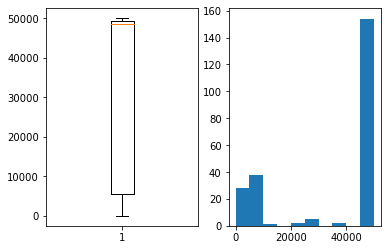

In [25]:
'''
Gerando alguns gráficos para análise
'''

fig, (ax1, ax2) = plt.subplots(1,2) #Uma linha e duas colunas. Cada um dos "ax" recebe um gráfico
ax1.boxplot(empty_entries_per_column)
ax2.hist(empty_entries_per_column)
median = empty_entries_per_column.median()
print(median)

'''
Em média, cada uma das variáveis possui 48.513 valores faltantes!
O boxplot indica que há uma quantidade muito grande de valores, pois a média está sendo indicada no topo do boxplot.
De acordo com o histograma 40 variáveis possuem, em média, 10 mil valores faltantes.
Com base nessa informação, e considerando que a base é desconhecida e os dados são mascarados, 
será realizado um corte na base de dados, excluindo as variáveis que possuem muitos valores ausentes.
'''

In [26]:
'''
num_entries armazena a quantidade de características ou variáveis do dataframe.
threshold (limiar, limite) representa a parte que será usada do total do dataframe
Todas as variáveis que possuem mais de 12500.0 valores faltantes serão excluídas
'''

num_entries = len(features)
threshold = 0.25
num_entries * threshold

12500.0

In [27]:
'''
keep_vars contém todas as variáveis (numéricas e categóricas) que atendem ao critério estabelecido: 
Valores faltantes ser menor ou igual a 12.500
'''
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries*threshold))])

In [28]:
keep_vars


array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192',
       'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [29]:
'''
Varrendo a lista de variáveis numéricas e categóricas, mantendo apenas as que estão dentro de keep_vars.
'''
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [30]:
len(num_vars)

38

In [31]:
len(cat_vars)

28

In [32]:
'''
É preciso tratar as variáveis numéricas e categóricas que ainda possuem valores faltantes.
Para variáveis Numéricas, os valores preenchidos com NaN serão preenchidos com a média.
fillna() fará o preenchimento com a média apenas se o valor for NaN.
Mais detalhes: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
'''
for col in num_vars:
    col_mean = features[col].mean()
    features[col] = features[col].fillna(col_mean)


In [33]:
'''
Para os daos categóricos, será incluída uma nova categoria chamada "missing".
Essa categoria será usada para substituir os dados faltantes.
Mais detalhes: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.add_categories.html
'''
for col in cat_vars:
    features[col] = features[col].cat.add_categories('missing')
    features[col] = features[col].fillna('missing')


In [34]:
'''
VIsualizando as alterações
'''
features.head()


Var1  Var2  Var3  Var4  Var5         Var6  Var7  Var8  Var9  Var10  ...  \
0   NaN   NaN   NaN   NaN   NaN  1526.000000   7.0   NaN   NaN    NaN  ...   
1   NaN   NaN   NaN   NaN   NaN   525.000000   0.0   NaN   NaN    NaN  ...   
2   NaN   NaN   NaN   NaN   NaN  5236.000000   7.0   NaN   NaN    NaN  ...   
3   NaN   NaN   NaN   NaN   NaN  1326.437116   0.0   NaN   NaN    NaN  ...   
4   NaN   NaN   NaN   NaN   NaN  1029.000000   7.0   NaN   NaN    NaN  ...   

    Var221   Var222      Var223  Var224  Var225  Var226   Var227  \
0     oslk  fXVEsaq  jySVZNlOJy     NaN     NaN    xb3V     RAYp   
1     oslk  2Kb5FSF  LM8l689qOp     NaN     NaN    fKCe     RAYp   
2  Al6ZaUT  NKv4yOc  jySVZNlOJy     NaN    kG3k    Qu4f  02N6s8f   
3     oslk  CE7uk3u  LM8l689qOp     NaN     NaN    FSa2     RAYp   
4     oslk  1J2cvxe  LM8l689qOp     NaN    kG3k    FSa2     RAYp   

          Var228  Var229  Var230  
0  F2FyR07IdsN7I     NaN     NaN  
1  F2FyR07IdsN7I     NaN     NaN  
2  ib5G6X1eUxUn6    am7c     NaN  
3  F2FyR07IdsN7I     NaN     NaN  
4  F2FyR07IdsN7I    mj86     NaN  

[5 rows x 230 columns]

### Tratando variáveis categóricas com muitas categorias

In [35]:
'''
Verificando quantas categorias que existem por features.
n_categories_per_feature receberá apenas as variáveis que estão dentro de cat_vars (28 variáveis).
A função lambda (definida em tempo de execução) retornará o número de valores únicos ordenados.
A função "set" poderia ser substituída pela função "unique" do NumPy.
Maiores detalhes: 
https://numpy.org/doc/stable/reference/generated/numpy.unique.html

'''

n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))

In [36]:
'''
Geralmente, quando se tem muitas categorias para atributos, isso não traz benefícios para os algoritmos.
Por desconhecer a base de dados, será realizado um corte baseado em um limiar para definir quais atributos
farão parte do dataset.
'''
n_categories_per_feature

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <BarContainer object of 10 artists>)

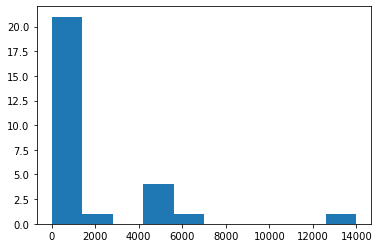

In [37]:
'''
Gerando um histograma para visualizar quais são os atributos que possuem mais categorias
'''

plt.hist(n_categories_per_feature)

Analisando o gráfico, podemos perceber que to total de 28 variáveis, mais de 20 possuem possuem menos de 2.000 categorias (aproximadamente 75%).

In [38]:
'''
Removendo de cat_vars todas as variáveis que possuem mais de 1.400 categorias.
O ".index" informa que será retornado o rótulo das variaveis.
Mais detalhe: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html
'''
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1400].index)

In [39]:
cat_vars

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [40]:
'''
Das 28 variáveis anteriores, apenas 21 passaram pelo filtro.
'''
len(cat_vars)

21

In [41]:
'''
Impornante notar que o formato de "cat_vars" e "num_vars" é array. É preciso transformar para o formato de lista
'''
cat_vars

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [42]:
'''
Unindo as variáveis numéricas e categóricas em um mesmo dataframe
'''

#Sobrescrevendo a variável features que é a base de dados
features = features[list(num_vars) + list(cat_vars)]

In [43]:
'''
Das 230 variáveis iniciais, o dataframe final possui apenas 59
'''
features.head()

Var6  Var7   Var13        Var21   Var22      Var24  Var25   Var28  \
0  1526.000000   7.0   184.0   464.000000   580.0  14.000000  128.0  166.56   
1   525.000000   0.0     0.0   168.000000   210.0   2.000000   24.0  353.52   
2  5236.000000   7.0   904.0  1212.000000  1515.0  26.000000  816.0  220.08   
3  1326.437116   0.0     0.0   234.518225     0.0   4.507926    0.0   22.08   
4  1029.000000   7.0  3216.0    64.000000    80.0   4.000000   64.0  200.00   

   Var35      Var38  ...  Var210  Var211         Var212   Var218  Var219  \
0    0.0     3570.0  ...    uKAI    L84s  XfqtO3UdzaXh_     cJvF    FzaX   
1    0.0  4764966.0  ...    uKAI    L84s        NhsEn4L  missing    FzaX   
2    0.0  5883894.0  ...    uKAI    L84s        UbxQ8lZ     UYBR    FzaX   
3    0.0        0.0  ...    uKAI    Mtgm        NhsEn4L     UYBR    FzaX   
4    0.0        0.0  ...    uKAI    L84s  XfqtO3UdzaXh_     UYBR    FzaX   

    Var221      Var223  Var226   Var227         Var228  
0     oslk  jySVZNlOJy    xb3V     RAYp  F2FyR07IdsN7I  
1     oslk  LM8l689qOp    fKCe     RAYp  F2FyR07IdsN7I  
2  Al6ZaUT  jySVZNlOJy    Qu4f  02N6s8f  ib5G6X1eUxUn6  
3     oslk  LM8l689qOp    FSa2     RAYp  F2FyR07IdsN7I  
4     oslk  LM8l689qOp    FSa2     RAYp  F2FyR07IdsN7I  

[5 rows x 59 columns]

In [44]:
features.shape

(50000, 59)

## Seleção de variáveis baseada em Árvores de Decisão

In [45]:
'''
Utilizando árvores de decisão para verificar a importância das variáveis
Detalhes: https://scikit-learn.org/stable/modules/feature_selection.html

Definição de variáveis do tipo Dummie - Transformação das categorias para o formato [100, 010, 001]
'''

feature_c = pd.get_dummies(features)

In [47]:
feature_c.shape

(50000, 1052)

In [50]:
'''
Base de dados com as variáveis dummies pronta, faremos a seleção de variáveis através de uma função.
A variável 'etc_importances' recebe os parâmetros e as variáveis de saída. É criado um classificador inteiro
e o próprio classificador será responsável por realizar aa previsões e retornar quais são as melhores características para a base de dados.
O modelo usado será um ExtraTreeClassifier, modelo parecido com o Random Forest que usa árvores de decisão.
Detalhes: https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/
OBS: ravel() transforma a saída (originalmente em formato de matriz) para o formato de vetor
'''

def etc_importances(features, outcome):
    modelo = ExtraTreesClassifier(n_estimators=200, criterion='entropy', verbose=0)
    modelo.fit(features, np.array(outcome).ravel())
    
    importances = modelo.feature_importances_
    variables = np.array(features.columns)
    indices = np.argsort(importances)[::-1] #[::-1] realizar o retorno
    importances = importances[indices]
    
    return variables, importances

In [51]:
variables , importances = etc_importances(feature_c, outcome)

In [55]:
variables

array(['Var6', 'Var7', 'Var13', ..., 'Var228_r_7E',
       'Var228_xwM2aC7IdeMC0', 'Var228_missing'], dtype=object)